## Binary regression model

In [107]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split,StratifiedShuffleSplit
from sklearn.metrics import recall_score, roc_auc_score, accuracy_score, precision_score
from imblearn.over_sampling import SMOTE
import pandas as pd
import numpy as np
rnd = 12

import lightgbm

import altair as alt
alt.renderers.enable('notebook')
alt.data_transformers.enable('default', max_rows=None)

DataTransformerRegistry.enable('default')

In [108]:
# load directly preprocessed dataframe
df = pd.read_excel('data/df.xlsx')

In [109]:
model_vars = ['customer_id','hour','weekday',
              'prch_freq','prch_last','prch_mean_diff',
              'cart_freq','cart_last','cart_mean_diff',
              'view_freq','view_last','view_mean_diff',
              'sess_freq','sess_last','sess_mean_diff',
              'email_freq','email_last','email_mean_diff']
model_df = df[model_vars]
Y = df.response

In [110]:
df = model_df
#for col in ['weekday']:
#    dummies = pd.get_dummies(df[col], prefix=col)
#    to_del = pd.get_dummies(df[col], prefix=col).columns[0]
#    dummies.drop(labels=to_del, axis=1, inplace=True)
#    df = pd.concat([df,dummies],axis=1)
#    df.drop([col],axis=1, inplace=True)

X = df

# Preprocessing

In [111]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=rnd, stratify=Y)
y_train = np.ravel(y_train)
y_test = np.ravel(y_test)
y_test_transformed = np.hstack((1 - y_test.reshape(y_test.size,1),
                                y_test.reshape(y_test.size,1)))

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(56272, 18) (56272,)
(6253, 18) (6253,)


# Simple frequency based approach

In [ ]:
simple = X_train[['hour','weekday']]
simple['response'] = y_train

In [ ]:
# take just 10+ delivered timewindows
sub = simple.groupby(['weekday', 'hour']).size().reset_index()
sub.columns
sub = sub[sub[0]>50]
sub['id'] = sub.weekday.astype(str) + 'id' + sub.hour.astype(str)
simple['id'] = simple.weekday.astype(str) + 'id' + simple.hour.astype(str)
sbset = simple[simple.id.isin(sub.id.tolist())]

In [ ]:
sbset = sbset.groupby(['weekday','hour']).mean().reset_index()
sbset.sort_values(by='response',ascending=False,inplace=True)
sbset.drop_duplicates('weekday',inplace=True)
sbset['id'] = sbset.weekday.astype(str) + 'id' + sbset.hour.astype(str)
X_test['id'] = X_test.weekday.astype(str) + 'id' + X_test.hour.astype(str)
sbset

In [115]:
pred = []
for i,row in X_test.iterrows():
    #print(row.id)
    if row.id in(sbset.id.tolist()):
        pred.append(1)
    else:
        pred.append(0)    

In [116]:
print('Test Results')
print("Accuracy: ",accuracy_score(pred, y_test))
print("Recall: ",recall_score(y_test, pred))
print("Precision: ",precision_score(y_test, pred))

Test Results
Accuracy:  0.569326723172877
Recall:  0.44804765056254137
Precision:  0.2669558359621451


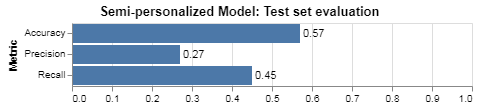

In [117]:
data = pd.DataFrame({
    'a': ['Accuracy','Recall','Precision'],
    'b': [round(accuracy_score(pred, y_test),2), round(recall_score(y_test, pred),2), round(precision_score(y_test, pred),2)]
})

bars = alt.Chart(data).mark_bar().encode(
    alt.X('b',scale=alt.Scale(domain=(0, 1)),axis=alt.Axis(title='')),
    alt.Y('a',axis=alt.Axis(title='Metric')),
).properties(title='Semi-personalized Model: Test set evaluation')

text = bars.mark_text(
    align='left',
    baseline='middle',
    dx=3
).encode(
    text='b'
)

bars + text

## Mode based approach

In [ ]:
md = X_train[['customer_id','hour','weekday']]
md['response'] = y_train

# determining only valid customers based on sample
md['freq'] = md[md.response==1].groupby('customer_id')['customer_id'].transform('count')
md = md[md.freq > 3]
md.drop('freq',1,inplace=True)

In [119]:
# modes for weekday and hour
mp = md[['customer_id','hour','weekday']].groupby(['customer_id','weekday']).apply(pd.DataFrame.mode).reset_index(drop=True)

In [ ]:
mp.dropna(inplace=True)
mp.weekday = mp.weekday.astype(int)
mp['id'] = mp.weekday.astype(str) + 'id' + mp.hour.astype(str)
mp['id2'] = mp.customer_id.astype(str) + ' - ' + mp.weekday.astype(str) + ' - ' + mp.hour.astype(str)
X_test['id2'] = X_test.customer_id.astype(str) + ' - ' + X_test.weekday.astype(str) + ' - ' + X_test.hour.astype(str)
X_test['id'] = X_test.weekday.astype(str) + 'id' + X_test.hour.astype(str)

In [121]:
# predictions

pred = []
for i,row in X_test.iterrows():
    # check if it is customer's mode hour for the weekday
    if row.id2 in(mp.id2.tolist()):
        pred.append(1)
    # check if it is mode for weekday in the population
    elif row.id in(sbset.id.tolist()):
        pred.append(1)
    else:    
        pred.append(0)    

In [122]:
print('Test Results')
print("Accuracy: ",accuracy_score(pred, y_test))
print("Recall: ",recall_score(y_test, pred))
print("Precision: ",precision_score(y_test, pred))

Test Results
Accuracy:  0.5619702542779466
Recall:  0.6161482461945731
Precision:  0.301294498381877


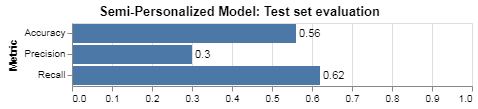

In [123]:
data = pd.DataFrame({
    'a': ['Accuracy','Recall','Precision'],
    'b': [round(accuracy_score(pred, y_test),2), round(recall_score(y_test, pred),2), round(precision_score(y_test, pred),2)]
})

bars = alt.Chart(data).mark_bar().encode(
    alt.X('b',scale=alt.Scale(domain=(0, 1)),axis=alt.Axis(title='')),
    alt.Y('a',axis=alt.Axis(title='Metric')),
).properties(title='Semi-Personalized Model: Test set evaluation')

text = bars.mark_text(
    align='left',
    baseline='middle',
    dx=3
).encode(
    text='b'
)

bars + text

# SMOTE

In [ ]:
# SMOTE
X_test.drop(['id','id2','customer_id'],1,inplace=True)
X_train.drop(['customer_id'],1,inplace=True)
sm = SMOTE(random_state=rnd, ratio = 1.0)
X_train_sm,Y_train_sm = sm.fit_sample(X_train, y_train)
X_train_sm = pd.DataFrame(X_train_sm)
X_train_sm.columns = X_train.columns
X_train_sm.weekday = X_train_sm.weekday.astype(int)
#X_train_sm.hour = X_train_sm.hour.astype(int)

In [125]:
X_train_sm.shape

(85340, 17)

In [126]:
y_test = np.ravel(y_test)
y_test_transformed = np.hstack((1 - y_test.reshape(y_test.size,1),
                                y_test.reshape(y_test.size,1)))

# Model for new customers

In [127]:
# change naming since xgboost has problems with this
X_train_naive = X_train_sm[['weekday','hour']]

In [16]:
# quick RF model based on whole dataset
clf_rf_naive = DecisionTreeClassifier(random_state=rnd,max_depth=3)
clf_rf_naive.fit(X_train_naive, Y_train_sm)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=12,
            splitter='best')

In [17]:
print('Validation Results')
print("Accuracy: ",clf_rf_naive.score(X_test[['weekday','hour']], y_test))
print("Recall: ",recall_score(y_test, clf_rf_naive.predict(X_test[['weekday','hour']])))
print("Precision: ",precision_score(y_test, clf_rf_naive.predict(X_test[['weekday','hour']])))
print("ROC AUC: ",roc_auc_score(y_test_transformed, clf_rf_naive.predict_proba(X_test[['weekday','hour']]),
                                average='weighted'))

Validation Results
Accuracy:  0.4343515112745882
Recall:  0.585043017868961
Precision:  0.23299947285187136
ROC AUC:  0.4885100295010777


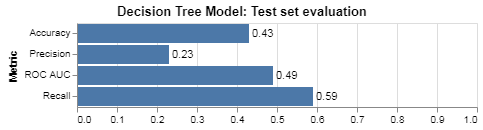

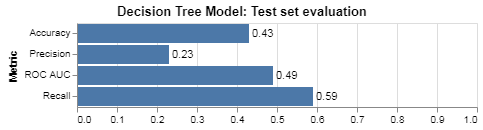

In [18]:
data = pd.DataFrame({
    'a': ['Accuracy','Recall','Precision','ROC AUC'],
    'b': [round(clf_rf_naive.score(X_test[['weekday','hour']], y_test),2),
          round(recall_score(y_test, clf_rf_naive.predict(X_test[['weekday','hour']])),2), 
          round(precision_score(y_test, clf_rf_naive.predict(X_test[['weekday','hour']])),2),
          round(roc_auc_score(y_test_transformed, clf_rf_naive.predict_proba(X_test[['weekday','hour']]),
                                average='weighted'),2)]
})

bars = alt.Chart(data).mark_bar().encode(
    alt.X('b',scale=alt.Scale(domain=(0, 1)),axis=alt.Axis(title='')),
    alt.Y('a',axis=alt.Axis(title='Metric')),
).properties(title='Decision Tree Model: Test set evaluation')

text = bars.mark_text(
    align='left',
    baseline='middle',
    dx=3
).encode(
    text='b'
)

bars + text

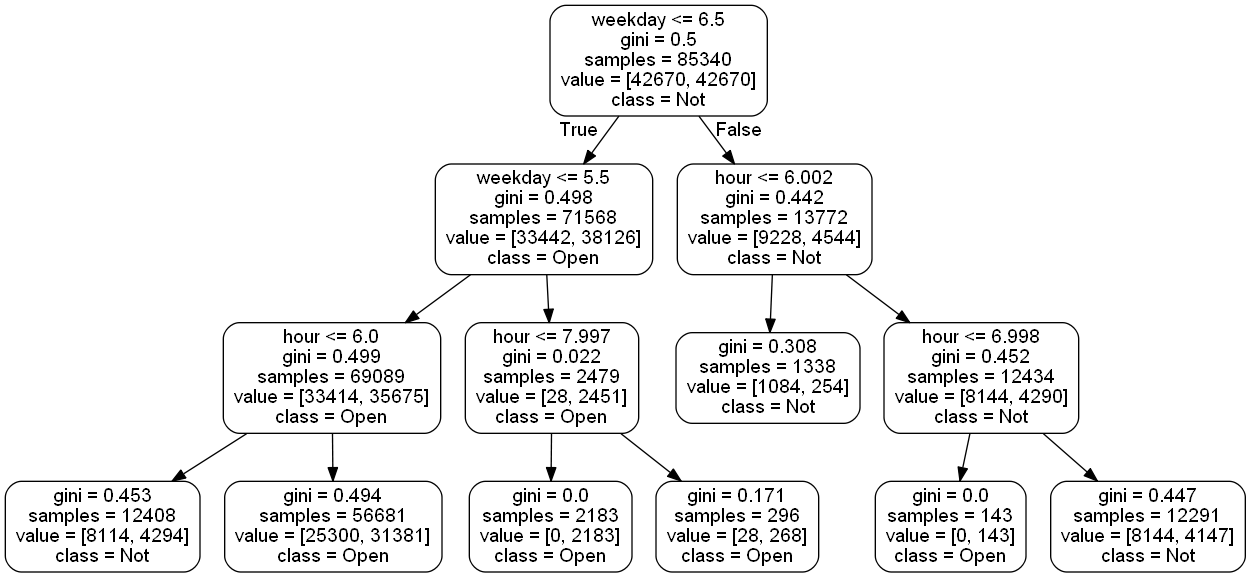

In [19]:
import pydotplus
from sklearn import tree
from IPython.display import Image 
# Create DOT data
dot_data = tree.export_graphviz(clf_rf_naive, out_file=None,
                               feature_names=['weekday','hour'],class_names=['Not','Open'],
                                rounded=True,
                               )

# Draw graph
graph = pydotplus.graph_from_dot_data(dot_data)  

# Show graph
Image(graph.create_png())

## Tuned Decision Tree

In [27]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

clf_dt = DecisionTreeClassifier()

CV_SSS = StratifiedShuffleSplit(n_splits=5, test_size=0.33, random_state=rnd)

dt_param_grid = {
                  'max_depth': np.arange(1, 25, 1),
                 }

random_grid_dt_CV = GridSearchCV(clf_dt,
                                        dt_param_grid,
                                        scoring = 'roc_auc',
                                        cv = CV_SSS)#,
                                        #n_iter = 5)
random_grid_dt_CV.fit(X_train_sm, Y_train_sm)
print(random_grid_dt_CV.best_score_)
print(random_grid_dt_CV.best_params_)

0.8910866962314462
{'max_depth': 11}


In [29]:
# quick RF model based on whole dataset
clf_dt = DecisionTreeClassifier(random_state=rnd,max_depth=11)
clf_dt.fit(X_train_naive, Y_train_sm)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=11,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=12,
            splitter='best')

In [30]:
print('Validation Results')
print("Accuracy: ",clf_dt.score(X_test[['weekday','hour']], y_test))
print("Recall: ",recall_score(y_test, clf_dt.predict(X_test[['weekday','hour']])))
print("Precision: ",precision_score(y_test, clf_dt.predict(X_test[['weekday','hour']])))
print("ROC AUC: ",roc_auc_score(y_test_transformed, clf_dt.predict_proba(X_test[['weekday','hour']]),
                                average='weighted'))

Validation Results
Accuracy:  0.7334079641771949
Recall:  0.062210456651224356
Precision:  0.27325581395348836
ROC AUC:  0.5169373002313138


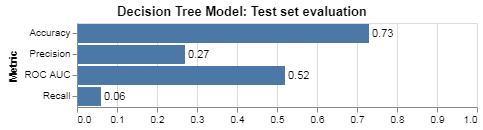

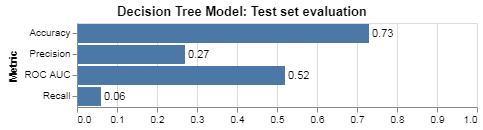

In [31]:
data = pd.DataFrame({
    'a': ['Accuracy','Recall','Precision','ROC AUC'],
    'b': [round(clf_dt.score(X_test[['weekday','hour']], y_test),2),
          round(recall_score(y_test, clf_dt.predict(X_test[['weekday','hour']])),2), 
          round(precision_score(y_test, clf_dt.predict(X_test[['weekday','hour']])),2),
          round(roc_auc_score(y_test_transformed, clf_dt.predict_proba(X_test[['weekday','hour']]),
                                average='weighted'),2)]
})

bars = alt.Chart(data).mark_bar().encode(
    alt.X('b',scale=alt.Scale(domain=(0, 1)),axis=alt.Axis(title='')),
    alt.Y('a',axis=alt.Axis(title='Metric')),
).properties(title='Decision Tree Model: Test set evaluation')

text = bars.mark_text(
    align='left',
    baseline='middle',
    dx=3
).encode(
    text='b'
)

bars + text

**This is by the way really interesting result even though it was not incorporated to final Report. This is clearly overfitted tree, with tendency to overshoot negative predicitions (hence Recall), was able to obtain 52% AUC ROC and obviously big Accuracy. This ROC can serve as good baseline for other models.**

# Baseline RF

In [ ]:
# quick RF model baseline
clf_rf = RandomForestClassifier(n_estimators=300, random_state=rnd,verbose=1)
clf_rf.fit(X_train_sm, Y_train_sm)

In [ ]:
print('Test Results')
print("Accuracy: ",clf_rf.score(X_test, y_test))
print("Recall: ",recall_score(y_test, clf_rf.predict(X_test)))
print("Precision: ",precision_score(y_test, clf_rf.predict(X_test)))
print("ROC AUC: ",roc_auc_score(y_test_transformed, clf_rf.predict_proba(X_test), average='weighted'))

In [ ]:
var_imp_clf_rf = pd.DataFrame({'vars': X_train_sm.columns,'imp':clf_rf.feature_importances_})
var_imp_clf_rf.sort_values(by='imp',ascending=False)

In [ ]:
data = pd.DataFrame({
    'a': ['Accuracy','Recall','Precision','ROC AUC'],
    'b': [round(clf_rf_naive.score(X_test, y_test),2),
          round(recall_score(y_test, clf_rf.predict(X_test)),2), 
          round(precision_score(y_test, clf_rf.predict(X_test)),2),
          round(roc_auc_score(y_test_transformed, clf_rf.predict_proba(X_test),
                                average='weighted'),2)]
})

bars = alt.Chart(data).mark_bar().encode(
    alt.X('b',scale=alt.Scale(domain=(0, 1)),axis=alt.Axis(title='')),
    alt.Y('a',axis=alt.Axis(title='Metric')),
).properties(title='Decision Tree Model: Test set evaluation')

text = bars.mark_text(
    align='left',
    baseline='middle',
    dx=3
).encode(
    text='b'
)

bars + text

## Hyperopt RF

In [ ]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

clf_rf = RandomForestClassifier()

CV_SSS = StratifiedShuffleSplit(n_splits=5, test_size=0.33, random_state=rnd)

rf_param_grid = {
                  'n_estimators': np.arange(20, 400, 20),
                 }

random_grid_rf_CV = RandomizedSearchCV(clf_rf,
                                        rf_param_grid,
                                        scoring = 'roc_auc',
                                        cv = CV_SSS,
                                        n_iter = 5)
random_grid_rf_CV.fit(X_train_sm, Y_train_sm)
print(random_grid_rf_CV.best_score_)
print(random_grid_rf_CV.best_params_)

In [ ]:
# quick RF model baseline
clf_rf = RandomForestClassifier(n_estimators=380, random_state=rnd,verbose=1)
clf_rf.fit(X_train_sm, Y_train_sm)

In [130]:
print('Test Results')
print("Accuracy: ",clf_rf.score(X_test, y_test))
print("Recall: ",recall_score(y_test, clf_rf.predict(X_test)))
print("Precision: ",recall_score(y_test, clf_rf.predict(X_test)))
print("ROC AUC: ",roc_auc_score(y_test_transformed, clf_rf.predict_proba(X_test), average='weighted'))

Test Results


[Parallel(n_jobs=1)]: Done 380 out of 380 | elapsed:    0.9s finished


Accuracy:  0.8132096593635055


[Parallel(n_jobs=1)]: Done 380 out of 380 | elapsed:    1.0s finished


Recall:  0.5579086697551291


[Parallel(n_jobs=1)]: Done 380 out of 380 | elapsed:    1.3s finished


Precision:  0.5579086697551291
ROC AUC:  0.8308758406299817


[Parallel(n_jobs=1)]: Done 380 out of 380 | elapsed:    1.0s finished


In [131]:
var_imp_clf_rf = pd.DataFrame({'vars': X_train_sm.columns,'imp':clf_rf.feature_importances_})
var_imp_clf_rf.sort_values(by='imp',ascending=False)

,vars,imp
14,email_freq,0.244642
16,email_mean_diff,0.136438
15,email_last,0.115115
0,hour,0.093334
12,sess_last,0.058806
9,view_last,0.052858
1,weekday,0.045423
10,view_mean_diff,0.040728
8,view_freq,0.040393
13,sess_mean_diff,0.038795


[Parallel(n_jobs=1)]: Done 380 out of 380 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Done 380 out of 380 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Done 380 out of 380 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Done 380 out of 380 | elapsed:    1.0s finished


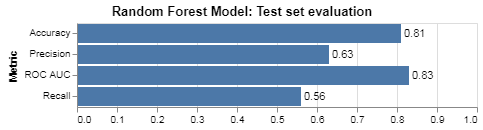

In [132]:
data = pd.DataFrame({
    'a': ['Accuracy','Recall','Precision','ROC AUC'],
    'b': [round(clf_rf.score(X_test, y_test),2),
          round(recall_score(y_test, clf_rf.predict(X_test)),2), 
          round(precision_score(y_test, clf_rf.predict(X_test)),2),
          round(roc_auc_score(y_test_transformed, clf_rf.predict_proba(X_test),
                                average='weighted'),2)]
})

bars = alt.Chart(data).mark_bar().encode(
    alt.X('b',scale=alt.Scale(domain=(0, 1)),axis=alt.Axis(title='')),
    alt.Y('a',axis=alt.Axis(title='Metric')),
).properties(title='Random Forest Model: Test set evaluation')

text = bars.mark_text(
    align='left',
    baseline='middle',
    dx=3
).encode(
    text='b'
)

bars + text

In [134]:
estimator = clf_rf.estimators_[5]

from sklearn.tree import export_graphviz
# Export as dot file
export_graphviz(estimator, out_file='tree5.dot', 
                feature_names = X_train.columns,
                class_names=['Not','Open'],
                rounded = True, proportion = False, 
                precision = 2, filled = True)

# XGBoost

In [294]:
#XGBoost

from sklearn.model_selection import StratifiedShuffleSplit, cross_val_score
from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import xgboost

XGB_Classifier = xgboost.XGBClassifier()

CV_SSS = StratifiedShuffleSplit(n_splits=5, test_size=0.33, random_state=rnd)

xgb_param_grid = {
                  'max_depth': np.arange(2, 40, 2),
                  'learning_rate': np.arange(0.2, 2, 0.2),
                  'n_estimators': np.arange(20, 400, 20),
                  'reg_alpha': np.arange(0, 2, 0.2),
                  'reg_lambda': np.arange(0, 2, 0.2)
                 }

random_grid_XGB_CV = RandomizedSearchCV(XGB_Classifier,
                                        xgb_param_grid,
                                        scoring = 'roc_auc',
                                        cv = CV_SSS,
                                        n_iter = 5)
random_grid_XGB_CV.fit(X_train_sm, Y_train_sm)
print(random_grid_XGB_CV.best_score_)
print(random_grid_XGB_CV.best_params_)

0.938320474250865
{'reg_lambda': 1.8, 'reg_alpha': 1.6, 'n_estimators': 260, 'max_depth': 32, 'learning_rate': 0.4}


In [295]:
# XGB_Classifier = random_grid_XGB_CV.best_estimator_
XGB_Classifier = xgboost.XGBClassifier(params={'reg_lambda': 1.8, 'reg_alpha': 1.6, 'n_estimators': 260, 
                                               'max_depth': 32, 'learning_rate': 0.4})
XGB_Classifier.fit(X_train_sm, Y_train_sm)
print(XGB_Classifier.feature_importances_)

[0.23333333 0.10289855 0.03768116 0.00434783 0.0115942  0.0057971
 0.0115942  0.01304348 0.01884058 0.02028986 0.05072464 0.0884058
 0.03333334 0.03188406 0.22753623 0.04202899 0.06666667]


In [296]:
#np.argmin(XGB_Classifier.feature_importances_)
y_score = XGB_Classifier.predict_proba(X_test)
X_test.columns[np.argmin(XGB_Classifier.feature_importances_)]

'prch_last'

In [297]:
print('Test Results')
print("Accuracy: ",XGB_Classifier.score(X_test, y_test))
print("Recall: ",recall_score(y_test, XGB_Classifier.predict(X_test)))
print("Precision: ",precision_score(y_test, XGB_Classifier.predict(X_test)))
print("ROC AUC: ",roc_auc_score(y_test_transformed, y_score, average='weighted'))

Test Results
Accuracy:  0.7890612505997121


C:\Users\chladek\AppData\Local\Continuum\anaconda3-64\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\chladek\AppData\Local\Continuum\anaconda3-64\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Recall:  0.57180675049636
Precision:  0.5625


C:\Users\chladek\AppData\Local\Continuum\anaconda3-64\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ROC AUC:  0.7985404237894412


In [298]:
var_imp_clf_rf = pd.DataFrame({'vars': X_train_sm.columns,'imp':XGB_Classifier.feature_importances_})
var_imp_clf_rf.sort_values(by='imp',ascending=False)

,vars,imp
0,hour,0.233333
14,email_freq,0.227536
1,weekday,0.102899
11,sess_freq,0.088406
16,email_mean_diff,0.066667
10,view_mean_diff,0.050725
15,email_last,0.042029
2,prch_freq,0.037681
12,sess_last,0.033333
13,sess_mean_diff,0.031884


C:\Users\chladek\AppData\Local\Continuum\anaconda3-64\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\chladek\AppData\Local\Continuum\anaconda3-64\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\chladek\AppData\Local\Continuum\anaconda3-64\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


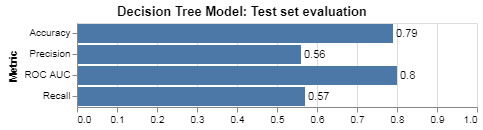

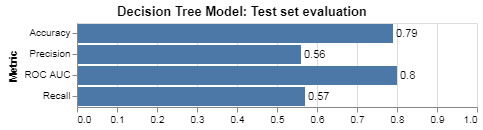

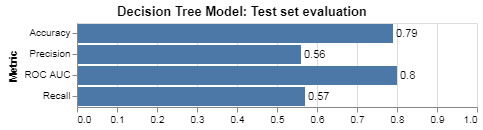

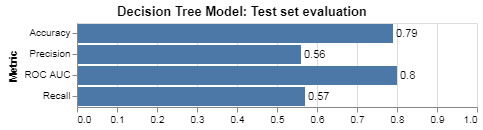

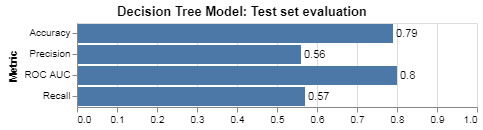

In [299]:
data = pd.DataFrame({
    'a': ['Accuracy','Recall','Precision','ROC AUC'],
    'b': [round(XGB_Classifier.score(X_test, y_test),2),
          round(recall_score(y_test, XGB_Classifier.predict(X_test)),2), 
          round(precision_score(y_test, XGB_Classifier.predict(X_test)),2),
          round(roc_auc_score(y_test_transformed, XGB_Classifier.predict_proba(X_test),
                                average='weighted'),2)]
})

bars = alt.Chart(data).mark_bar().encode(
    alt.X('b',scale=alt.Scale(domain=(0, 1)),axis=alt.Axis(title='')),
    alt.Y('a',axis=alt.Axis(title='Metric')),
).properties(title='Decision Tree Model: Test set evaluation')

text = bars.mark_text(
    align='left',
    baseline='middle',
    dx=3
).encode(
    text='b'
)

bars + text

In [ ]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_test_transformed[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
lw = 2

plt.plot(fpr[1], tpr[1], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

# LightGBM

In [301]:
#
# Create the LightGBM data containers
#
categorical_features = [c for c, col in enumerate(X_train_sm.columns) if 'cat' in col]
train_data = lightgbm.Dataset(X_train_sm, label=Y_train_sm, categorical_feature=categorical_features)
test_data = lightgbm.Dataset(X_test, label=y_test)

parameters = {
    'application': 'binary',
    'objective': 'binary',
    'metric': 'auc',
    'is_unbalance': 'false',
    'boosting': 'gbdt',
    'feature_fraction': 0.5,
    'bagging_fraction': 0.5,
    'bagging_freq': 20,
    'learning_rate': 0.05,
    'verbose': -1

}

CV_SSS = StratifiedShuffleSplit(n_splits=5, test_size=0.33, random_state=None)

lightgbm_param_grid = {
                  'max_depth': np.arange(2, 40, 2),
                  'learning_rate': np.arange(0.2, 2, 0.2),
                  'n_estimators': np.arange(20, 400, 10),
                  'reg_alpha': np.arange(0, 2, 0.2),
                  'reg_lambda': np.arange(0, 2, 0.2),
                  'max_bin': np.arange(300, 600, 5),
                  'num_leaves':np.arange(31,60,1)
                 }

estimator = lightgbm.LGBMClassifier(application='binary',objective='binary',metric='roc_auc',is_unbalance='false',boosting= 'gbdt')

random_grid_GBM_CV = RandomizedSearchCV(estimator,
                                        lightgbm_param_grid,
                                        scoring = 'roc_auc',
                                        cv = CV_SSS,
                                        n_iter = 5)

random_grid_GBM_CV.fit(X_train_sm, Y_train_sm)

print('Best parameters found by random search are:', random_grid_GBM_CV.best_params_)
print('Best score found by random search are:', random_grid_GBM_CV.best_score_)

Best parameters found by grid search are: {'reg_lambda': 0.6000000000000001, 'reg_alpha': 0.2, 'num_leaves': 44, 'n_estimators': 140, 'max_depth': 30, 'max_bin': 475, 'learning_rate': 0.8}
Best score found by grid search are: 0.9284318191054031


In [302]:
# specify your configurations as a dict
params = {
    'application': 'binary',
    'objective': 'binary',
    'metric': 'recall',
    'is_unbalance': 'false',
    'boosting': 'gbdt',
    'reg_lambda': 0.6,
    'reg_alpha': 0.2,
    'num_leaves': 44,
    'n_estimators': 140,
    'max_depth': 30,
    'learning_rate': 0.8,
    'verbose': -1,
    'max_bin': 475
}
# fit
gbm = lightgbm.LGBMClassifier(**params)
gbm.fit(X_train_sm, Y_train_sm)

print(gbm.feature_importances_)

#print('Save model...')
# save model to file
#gbm.save_model('model.txt')

print('Start predicting...')
# predict
y_pred = gbm.predict(X_test)
y_score = gbm.predict_proba(X_test)

[255 294  70 187  29 130 266 217 349 561 423 250 598 452 520 770 649]
Start predicting...


C:\Users\chladek\AppData\Local\Continuum\anaconda3-64\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [303]:
print('Test Results')
print("Accuracy: ",gbm.score(X_test, y_test))
print("Recall: ",recall_score(y_test, gbm.predict(X_test)))
print("Precision: ",precision_score(y_test, gbm.predict(X_test)))
print("ROC AUC: ",roc_auc_score(y_test_transformed, y_score, average='weighted'))

Test Results
Accuracy:  0.8151287382056612
Recall:  0.5387160820648577


C:\Users\chladek\AppData\Local\Continuum\anaconda3-64\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\chladek\AppData\Local\Continuum\anaconda3-64\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\chladek\AppData\Local\Continuum\anaconda3-64\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Precision:  0.6394344069128044
ROC AUC:  0.8059729144993513


In [304]:
var_imp_clf_rf = pd.DataFrame({'vars': X_train_sm.columns,'imp':gbm.feature_importances_})
var_imp_clf_rf.sort_values(by='imp',ascending=False)

,vars,imp
15,email_last,770
16,email_mean_diff,649
12,sess_last,598
9,view_last,561
14,email_freq,520
13,sess_mean_diff,452
10,view_mean_diff,423
8,view_freq,349
1,weekday,294
6,cart_last,266


C:\Users\chladek\AppData\Local\Continuum\anaconda3-64\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\chladek\AppData\Local\Continuum\anaconda3-64\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\chladek\AppData\Local\Continuum\anaconda3-64\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


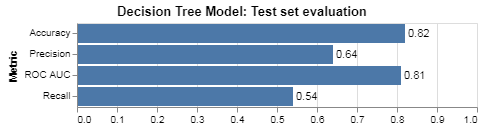

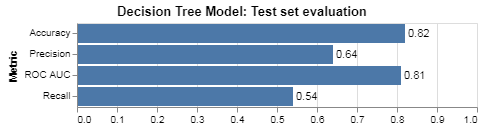

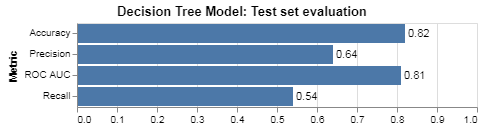

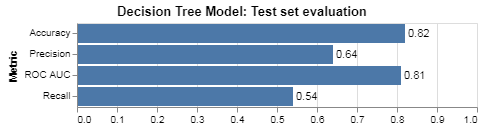

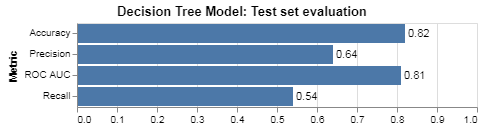

In [305]:
data = pd.DataFrame({
    'a': ['Accuracy','Recall','Precision','ROC AUC'],
    'b': [round(gbm.score(X_test, y_test),2),
          round(recall_score(y_test, gbm.predict(X_test)),2), 
          round(precision_score(y_test, gbm.predict(X_test)),2),
          round(roc_auc_score(y_test_transformed, gbm.predict_proba(X_test),
                                average='weighted'),2)]
})

bars = alt.Chart(data).mark_bar().encode(
    alt.X('b',scale=alt.Scale(domain=(0, 1)),axis=alt.Axis(title='')),
    alt.Y('a',axis=alt.Axis(title='Metric')),
).properties(title='Decision Tree Model: Test set evaluation')

text = bars.mark_text(
    align='left',
    baseline='middle',
    dx=3
).encode(
    text='b'
)

bars + text